In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ead in data (NEED TO TALK ABT THIS)

In [37]:
twitter = pd.read_csv('FakeNewsNet.csv') #ONLY INCLUDES TITLES OF ARTICLES
#print(twitter.head(10))
#twitter = twitter.drop(['news_url', 'source_domain', 'tweet_num'], axis=1)
print(twitter.head(10)) 
print(twitter.columns)

                                               title  \
0  Kandi Burruss Explodes Over Rape Accusation on...   
1  People's Choice Awards 2018: The best red carp...   
2  Sophia Bush Sends Sweet Birthday Message to 'O...   
3  Colombian singer Maluma sparks rumours of inap...   
4  Gossip Girl 10 Years Later: How Upper East Sid...   
5  Gwen Stefani Got Dumped by Blake Shelton Over ...   
6  Broward County Sheriff Fired For Lying About P...   
7  Amber Rose Shuts Down French Montana Dating Ru...   
8  Mindy Kaling makes first post-baby appearance ...   
9  Katharine McPhee Butchers Tony Nominations: “I...   

                                            news_url          source_domain  \
0  http://toofab.com/2017/05/08/real-housewives-a...             toofab.com   
1  https://www.today.com/style/see-people-s-choic...          www.today.com   
2  https://www.etonline.com/news/220806_sophia_bu...       www.etonline.com   
3  https://www.dailymail.co.uk/news/article-33655...    www.dailyma

ead in albanian data

In [38]:
albanian = pd.read_csv('alb-fake-news-corpus.csv')
print(albanian.head(10))
print(albanian.columns)

                                               title  \
0  Studimi gjerman: Gjysma e pacientëve me COVID-...   
1  Labinot Tahiri: Gjyshes 87-vjeçare nga Istogu ...   
2  Parashikon Albulena Haxhiu: Shpejt shihemi në ...   
3             Covid-19 rriti lajmet e rreme në media   
4  Kryeministri Hoti edhe sot i shkoi në zyre Pre...   
5  Hoti: Do t’i dyfishojmë dhe trefishojmë testim...   
6  Prokuroria: I dyshuari e privoi nga jeta gruan...   
7  Prokuroria: I dyshuari e privoi nga jeta gruan...   
8  Alarmante - Rreth 3 mijë raste aktive me COVID...   
9  Numri i të infektuarve të sotëm me COVID-19 në...   

                                             content  publication_datetime  \
0  Një nga pesë pacientë që ishin të shtruar kohë...  2020/07/29, 23:12:48   
1  Zojë Haxhiaj nga Rakoshi i Istogut kishte mbet...  2020/07/29, 21:36:47   
2  Ish-ministrja e Drejtësisë, Albulena Haxhiu, k...  2020/07/29, 00:16:23   
3  Që nga 13 marsi kur në Kosovë u regjistrua ras...  2020/07/25, 17:46

ead and clean soccer data

In [39]:
fakeSoccer = pd.read_csv('fake-soccer.csv')
realSoccer = pd.read_csv('real-soccer.csv')
fakeSoccer['real'] = 0
realSoccer['real'] = 1
soccer = pd.concat([fakeSoccer, realSoccer])
soccer['tweet'] = soccer['tweet'].fillna("").astype(str) # Fill NaNs and convert to string fixes errors
print(soccer.head(10))

                                               tweet  real
0  the tongue of his condition, now i saw things ...     0
1  by god the great, after i saw the derby of wyd...     0
2  believe in god, this zamalek fans are as good ...     0
3  the coach appeared in the media and told the t...     0
4  asno smito\nwhoever knows her tells me a massa...     0
5  \nthe dirty referee is a sieve on the mouse, i...     0
6   _ portugal argentine referee and understand f...     0
7  honestly, when al-ahly and al-hilal match tick...     0
8  ashraf sobhi, minister of kindness:\nwe follow...     0
9  i am of the opinion to stop the league and pla...     0


tart naive bayes

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import re
from collections import Counter

In [41]:
def tokenize(text):
    return re.findall(r'\b\w+\b|[!?.,;]', text.lower())  

In [42]:
def naive_bayes_classifier_count(data, content_col, label_col, test_size=0.2, random_state=42, top_n=10):
    """
    Reusable function for Naive Bayes classification
    
    Args:
    data: pandas DataFrame
    content_col: column name containing text data (content for Albaian data)
    label_col: column name containing labels (fake_news for Albanian data)
    test_size: proportion of data to use for testing
    Returns:
    accuracy: accuracy of classifier
    top_words: top words influencing fake news (top 10, can change in function header at top_n)
    """

In [43]:
    data['tokens'] = data[content_col].apply(tokenize)

    # real/fake tokens
    fake_tokens = data[data[label_col] == 1]['tokens'].explode()
    real_tokens = data[data[label_col] == 0]['tokens'].explode()
    fake_word_counts = Counter(fake_tokens)
    real_word_counts = Counter(real_tokens)
    total_fake_words = sum(fake_word_counts.values())
    total_real_words = sum(real_word_counts.values())
    vocab = set(fake_word_counts.keys()).union(set(real_word_counts.keys()))
    vocab_size = len(vocab)

    #laplace smoothing for word likelihoods
    word_likelihoods = {
        word: {
            'fake': (fake_word_counts[word] + 1) / (total_fake_words + vocab_size),
            'real': (real_word_counts[word] + 1) / (total_real_words + vocab_size)
        }
        for word in vocab
    }

    #nb prediction
    def predict_nb(content, likelihoods, prior_fake, prior_real):
        tokens = tokenize(content)
        log_prob_fake = np.log(prior_fake)
        log_prob_real = np.log(prior_real)
        for token in tokens:
            if token in likelihoods:
                log_prob_fake += np.log(likelihoods[token]['fake'])
                log_prob_real += np.log(likelihoods[token]['real'])
        return 1 if log_prob_fake > log_prob_real else 0 # 1 is fake, 0 is real

    # run classifier
    train, test = train_test_split(data, test_size=test_size, random_state=random_state)
    prior_fake = train[label_col].mean()
    prior_real = 1 - prior_fake
    test['predicted'] = test[content_col].apply(
        predict_nb, args=(word_likelihoods, prior_fake, prior_real)
    )
    accuracy = accuracy_score(test[label_col], test['predicted'])
    print(f"NB (w/ laplace smoothing Accuracy: {accuracy}")

    # print top words influencing fake news
    word_influence = {
        word: np.log(likelihood['fake']) - np.log(likelihood['real'])
        for word, likelihood in word_likelihoods.items()
    }
    sorted_words = sorted(word_influence.items(), key=lambda x: x[1], reverse=True)
    top_words = sorted_words[:top_n]
    print("Top words pulling toward fake news:")
    for word, influence in top_words:
        print(f"Word: {word}, Pull: {influence:.4f}")
    
    # Plot misclassified 
    misclassified = test[test[label_col] != test['predicted']]
    plt.figure(figsize=(10, 6))
    plt.hist(misclassified[content_col].apply(len), bins=20, color='red', alpha=0.7, label='Misclassified')
    plt.hist(test[content_col].apply(len), bins=20, color='blue', alpha=0.5, label='All')
    plt.xlabel('Length of Content')
    plt.ylabel('Frequency')
    plt.title('Distribution of Content Lengths for Misclassified Examples')
    plt.legend()
    plt.show()
    
  
    return accuracy, top_words

NameError: name 'data' is not defined

In [44]:
def naive_bayes_classifier_tfidf(data, content_col, label_col, test_size=0.2, random_state=42, top_n=10, alpha=1.0):
    """
    Reusable function for Naive Bayes classification using TF-IDF vectorization and Laplace smoothing.
    
    Args:
    data: pandas DataFrame
    content_col: column name containing text data
    label_col: column name containing labels
    test_size: proportion of data to use for testing
    random_state: random seed for reproducibility
    top_n: number of top influential words to display
    alpha: smoothing parameter for Laplace smoothing in Naive Bayes
    Returns:
    accuracy: accuracy of classifier
    top_words: top words influencing fake news (top_n)
    """
    # Preprocess text
    data['tokens'] = data[content_col].apply(lambda x: ' '.join(tokenize(x)))

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        data['tokens'], data[label_col], test_size=test_size, random_state=random_state
    )
    vectorizer = TfidfVectorizer()
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    nb_model = MultinomialNB(alpha=alpha)
    nb_model.fit(X_train_vec, y_train)
    y_pred = nb_model.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Naive Bayes Accuracy (with alpha={alpha}): {accuracy:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    feature_names = vectorizer.get_feature_names_out()
    feature_log_probs = nb_model.feature_log_prob_[1] - nb_model.feature_log_prob_[0]
    top_indices = feature_log_probs.argsort()[::-1][:top_n]
    top_words = [(feature_names[i], feature_log_probs[i]) for i in top_indices]
    print(f"\nTop {top_n} Influential Words:")
    for word, score in top_words:
        print(f"Word: {word}, Score: {score:.4f}")

    #plot misclassified
    misclassified = data.loc[y_test[y_test != y_pred].index]
    plt.figure(figsize=(10, 6))
    plt.hist(misclassified[content_col].apply(len), bins=20, color='red', alpha=0.7, label='Misclassified')
    plt.hist(data[content_col].apply(len), bins=20, color='blue', alpha=0.5, label='All')
    plt.xlabel('Length of Content')
    plt.ylabel('Frequency')
    plt.title('Distribution of Content Lengths for Misclassified Examples')
    plt.legend()
    plt.show()
    
    return accuracy, top_words

tart knn

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

URSE OF DIMENTIONALITY

In [46]:
def knn_classifier(data, content_col, label_col, test_size=0.2, random_state=42, n_neighbors=10, top_n=10):
    data['tokens'] = data[content_col].apply(tokenize)
    data['tokens'] = data['tokens'].apply(lambda x: ' '.join(x))
    X_train, X_test, y_train, y_test = train_test_split(data['tokens'], data[label_col], test_size=test_size, random_state=random_state)

    # vectorize text data using TF-IDF useful for KNN 
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"KNN Accuracy: {accuracy:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # get influential features
    feature_names = vectorizer.get_feature_names_out()
    feature_scores = X_train.mean(axis=0).A1  
    top_indices = feature_scores.argsort()[::-1][:top_n]  
    top_features = [(feature_names[i], feature_scores[i]) for i in top_indices]
    print(f"\nTop {top_n} Influential Features:")
    for feature, score in top_features:
        print(f"Feature: {feature}, Score: {score:.4f}")

    #plot 
    plt.figure(figsize=(10, 6))
    words, scores = zip(*top_features)
    plt.barh(words, scores, color='skyblue', edgecolor='black')
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.title(f"Top {top_n} Influential Features for KNN Classification")
    plt.xlabel("Feature Scores (TF-IDF Mean)")
    plt.ylabel("Words")
    plt.tight_layout()
    plt.show()
    return accuracy, top_features

tart svm

In [47]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [48]:
def svm_classifier(data, content_col, label_col, test_size=0.2, random_state=42):
    """
    Reusable function for SVM classification
    
    Args:
    data: pandas DataFrame
    content_col: column name containing text data
    label_col: column name containing labels
    test_size: proportion of data to use for testing
    Returns:
    accuracy: accuracy of classifier
    """
    data['tokens'] = data[content_col].apply(tokenize)
    data['tokens'] = data['tokens'].apply(lambda x: ' '.join(x))
    X_train, X_test, y_train, y_test = train_test_split(data['tokens'], data[label_col], test_size=test_size, random_state=random_state)

    # vectorize text data using TF-IDF
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # standardize features
    scaler = StandardScaler(with_mean=False)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # train SVM
    svm = SVC()
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"SVM Accuracy: {accuracy:.2f}")

    #print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm = confusion_matrix(y_test, y_pred, labels=svm.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix for SVM')
    plt.show()
    return accuracy

In [49]:
from sklearn.tree import DecisionTreeClassifier, export_text
def decision_tree_classifier(data, content_col, label_col, test_size=0.2, random_state=42, top_n=10, max_depth_range=(1, 50)):
    data['tokens'] = data[content_col].apply(tokenize)
    data['tokens'] = data['tokens'].apply(lambda x: ' '.join(x))
    X_train, X_test, y_train, y_test = train_test_split(data['tokens'], data[label_col], test_size=test_size, random_state=random_state)
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    best_accuracy = 0
    best_max_depth = None
    best_top_features = None
    
    for max_depth in range(max_depth_range[0], max_depth_range[1] + 1):
        dt = DecisionTreeClassifier(random_state=random_state, max_depth=max_depth)
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_max_depth = max_depth
    print(f"\nBest Max Depth: {best_max_depth}")
    print(f"Best Accuracy: {best_accuracy:.2f}")
    print(f"\nTop {top_n} Influential Features:")
    from sklearn.tree import plot_tree
    plt.figure(figsize=(20, 10))
    plot_tree(dt, feature_names=vectorizer.get_feature_names_out(), max_depth=2, filled=True)
    plt.show()
    
    return best_accuracy, best_max_depth, best_top_features

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [51]:
def random_forest_classifier(data, content_col, label_col, test_size=0.2, random_state=42, top_n=10, n_estimators=100):
   
    data['tokens'] = data[content_col].apply(tokenize)
    data['tokens'] = data['tokens'].apply(lambda x: ' '.join(x))
    X_train, X_test, y_train, y_test = train_test_split(data['tokens'], data[label_col], test_size=test_size, random_state=random_state)
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    accuracy_list = []  # Store accuracy for each number of estimators
    best_accuracy = 0
    best_n_estimators = None
    feature_importances = None
    for n in range(1, n_estimators + 1):
        rf = RandomForestClassifier(random_state=random_state, n_estimators=n)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_list.append(accuracy)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_n_estimators = n
            feature_importances = rf.feature_importances_  
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, n_estimators + 1), accuracy_list, marker='o', color='blue', label='Accuracy')
    plt.axvline(x=best_n_estimators, color='red', linestyle='--', label=f'Best Estimators: {best_n_estimators}')
    plt.title('Accuracy vs. Number of Estimators (Random Forest)')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()
    if feature_importances is not None:
        feature_names = vectorizer.get_feature_names_out()
        top_indices = feature_importances.argsort()[::-1][:top_n]
        top_features = [(feature_names[i], feature_importances[i]) for i in top_indices]
        
        # Bar chart for top features
        plt.figure(figsize=(8, 6))
        feature_names_plot, importance_scores = zip(*top_features)
        plt.barh(feature_names_plot, importance_scores, color='green', alpha=0.7)
        plt.title(f'Top {top_n} Influential Features')
        plt.xlabel('Feature Importance')
        plt.gca().invert_yaxis()  
        plt.tight_layout()
        plt.show()
    else:
        top_features = None
    print(f"\nBest Number of Estimators: {best_n_estimators}")
    print(f"Best Accuracy: {best_accuracy:.2f}")
    return best_accuracy, best_n_estimators, top_features

In [52]:
from sklearn.linear_model import LogisticRegression

In [53]:
def logistic_regression_classifier(data, content_col, label_col, test_size=0.2, random_state=42):
    """
    Reusable function for logistic regression classification
    
    Args:
    data: pandas DataFrame
    content_col: column name containing text data
    label_col: column name containing labels
    test_size: proportion of data to use for testing
    Returns:
    accuracy: accuracy of classifier
    """
    data['tokens'] = data[content_col].apply(tokenize)
    data['tokens'] = data['tokens'].apply(lambda x: ' '.join(x))
    X_train, X_test, y_train, y_test = train_test_split(data['tokens'], data[label_col], test_size=test_size, random_state=random_state)
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    scaler = StandardScaler(with_mean=False)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Logistic Regression Accuracy: {accuracy:.2f}")
    return accuracy

In [54]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
def lda_classifier(data, content_col, label_col, test_size=0.2, random_state=42):
    """
    Reusable function for LDA classification
    
    Args:
    data: pandas DataFrame
    content_col: column name containing text data
    label_col: column name containing labels
    test_size: proportion of data to use for testing
    Returns:
    accuracy: accuracy of classifier
    """
    data['tokens'] = data[content_col].apply(tokenize)
    data['tokens'] = data['tokens'].apply(lambda x: ' '.join(x))
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(data['tokens'], data[label_col], test_size=test_size, random_state=random_state)
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(X_train).toarray()  
    X_test = vectorizer.transform(X_test).toarray()       

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"LDA Accuracy: {accuracy:.2f}")
    return accuracy

In [55]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
def qda_classifier(data, content_col, label_col, test_size=0.2, random_state=42):
    """
    Reusable function for QDA classification
    
    Args:
    data: pandas DataFrame
    content_col: column name containing text data
    label_col: column name containing labels
    test_size: proportion of data to use for testing
    Returns:
    accuracy: accuracy of classifier
    """
    data['tokens'] = data[content_col].apply(tokenize)
    data['tokens'] = data['tokens'].apply(lambda x: ' '.join(x))
    X_train, X_test, y_train, y_test = train_test_split(data['tokens'], data[label_col], test_size=test_size, random_state=random_state)
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(X_train).toarray()  
    X_test = vectorizer.transform(X_test).toarray()   
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train QDA
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(X_train, y_train)
    y_pred = qda.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"QDA Accuracy: {accuracy:.2f}")
    return accuracy

In [56]:
from sklearn.neural_network import MLPClassifier
def neural_network_classifier(data, content_col, label_col, test_size=0.2, random_state=42):
    """
    Reusable function for neural network classification
    
    Args:
    data: pandas DataFrame
    content_col: column name containing text data
    label_col: column name containing labels
    test_size: proportion of data to use for testing
    Returns:
    accuracy: accuracy of classifier
    """
    data['tokens'] = data[content_col].apply(tokenize)
    data['tokens'] = data['tokens'].apply(lambda x: ' '.join(x))
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(data['tokens'], data[label_col], test_size=test_size, random_state=random_state)

    # Vectorize text data using TF-IDF
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(X_train).toarray()  # Convert sparse matrix to dense
    X_test = vectorizer.transform(X_test).toarray()        # Convert sparse matrix to dense

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train neural network
    nn = MLPClassifier()
    nn.fit(X_train, y_train)
    y_pred = nn.predict(X_test)

    # Evaluate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Neural Network Accuracy: {accuracy:.2f}")

In [57]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

In [58]:
def hybrid_knn_naive_bayes(data, content_col, label_col, test_size=0.2, random_state=42, weight_nb=0.6, weight_knn=0.4, n_neighbors=5):
    """
    Hybrid model combining Naive Bayes and KNN for classification.
    Args:
        data (DataFrame): Input data containing text and labels.
        content_col (str): Name of the column containing text data.
        label_col (str): Name of the column containing labels.
        test_size (float): Proportion of the data to use for testing.
        random_state (int): Random seed for reproducibility.
        weight_nb (float): Weight for Naive Bayes predictions.
        weight_knn (float): Weight for KNN predictions.
        n_neighbors (int): Number of neighbors for KNN.
    Returns:
        accuracy (float): Accuracy of the hybrid model.
    """
    data['tokens'] = data[content_col].apply(tokenize)
    data['tokens'] = data['tokens'].apply(lambda x: ' '.join(x))
    X_train, X_test, y_train, y_test = train_test_split(
        data['tokens'], data[label_col], test_size=test_size, random_state=random_state
    )
    vectorizer = TfidfVectorizer()
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)

    #NB
    nb_model = MultinomialNB()
    nb_model.fit(X_train_vectorized, y_train)
    nb_probs = nb_model.predict_proba(X_test_vectorized)

    #KNN
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_model.fit(X_train_vectorized, y_train)
    knn_probs = knn_model.predict_proba(X_test_vectorized)

    # Combine predictions using weighted voting
    combined_probs = (weight_nb * nb_probs) + (weight_knn * knn_probs)
    y_pred = combined_probs.argmax(axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Hybrid Model Accuracy: {accuracy}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    def plot_model_contributions(weight_nb, weight_knn):
        plt.figure(figsize=(6, 5))
        plt.bar(['Naive Bayes', 'KNN'], [weight_nb, weight_knn], color=['skyblue', 'lightgreen'])
        plt.ylabel('Weight Contribution')
        plt.title('Hybrid Model Contributions')
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.show()
    plot_model_contributions(weight_nb, weight_knn)
    return accuracy

In [59]:
def hybrid_nb_lr(data, content_col, label_col, test_size=0.2, random_state=42):
    """
    Hybrid model combining Naive Bayes and Logistic Regression.
    """
    data['tokens'] = data[content_col].apply(lambda x: ' '.join(tokenize(x)))
    X_train, X_test, y_train, y_test = train_test_split(data['tokens'], data[label_col], test_size=test_size, random_state=random_state)
    
    vectorizer = TfidfVectorizer()
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    
    # nb
    nb = MultinomialNB()
    nb.fit(X_train_vec, y_train)
    nb_train_probs = nb.predict_proba(X_train_vec)
    nb_test_probs = nb.predict_proba(X_test_vec)
    
    # logistic on nb
    lr = LogisticRegression()
    lr.fit(nb_train_probs, y_train)
    y_pred = lr.predict(nb_test_probs)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Hybrid NB + LR Accuracy: {accuracy}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return accuracy

un classifiers

rint accuracies

In [60]:
accuracies = {}
accuracies['albanian'] = {}
accuracies['soccer'] = {}
accuracies['twitter'] = {}

KNN Accuracy: 0.72

Classification Report:
              precision    recall  f1-score   support

       False       0.66      0.99      0.79       429
        True       0.97      0.42      0.58       370

    accuracy                           0.72       799
   macro avg       0.82      0.70      0.69       799
weighted avg       0.80      0.72      0.70       799


Top 10 Influential Features:
Feature: të, Score: 0.1393
Feature: në, Score: 0.0832
Feature: dhe, Score: 0.0535
Feature: për, Score: 0.0509
Feature: ka, Score: 0.0462
Feature: me, Score: 0.0457
Feature: që, Score: 0.0428
Feature: një, Score: 0.0402
Feature: se, Score: 0.0392
Feature: është, Score: 0.0337


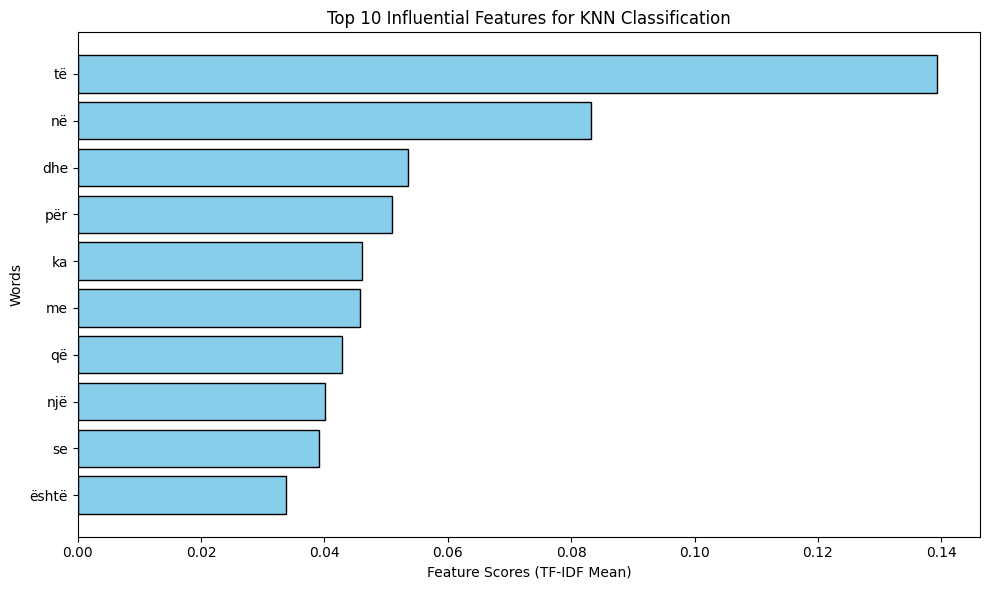

SVM Accuracy: 0.69

Classification Report:
              precision    recall  f1-score   support

       False       0.65      0.89      0.75       429
        True       0.78      0.45      0.57       370

    accuracy                           0.69       799
   macro avg       0.72      0.67      0.66       799
weighted avg       0.71      0.69      0.67       799



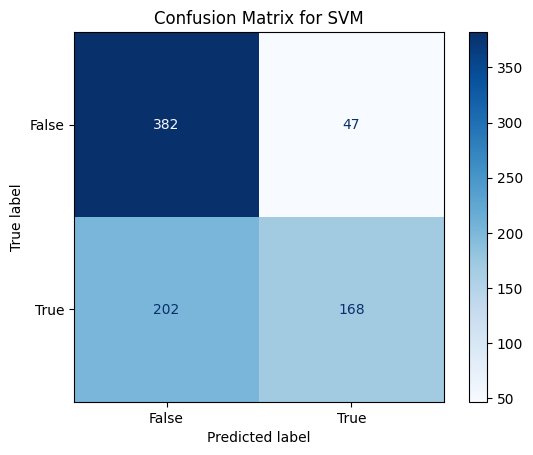


Best Max Depth: 17
Best Accuracy: 0.85

Top 10 Influential Features:


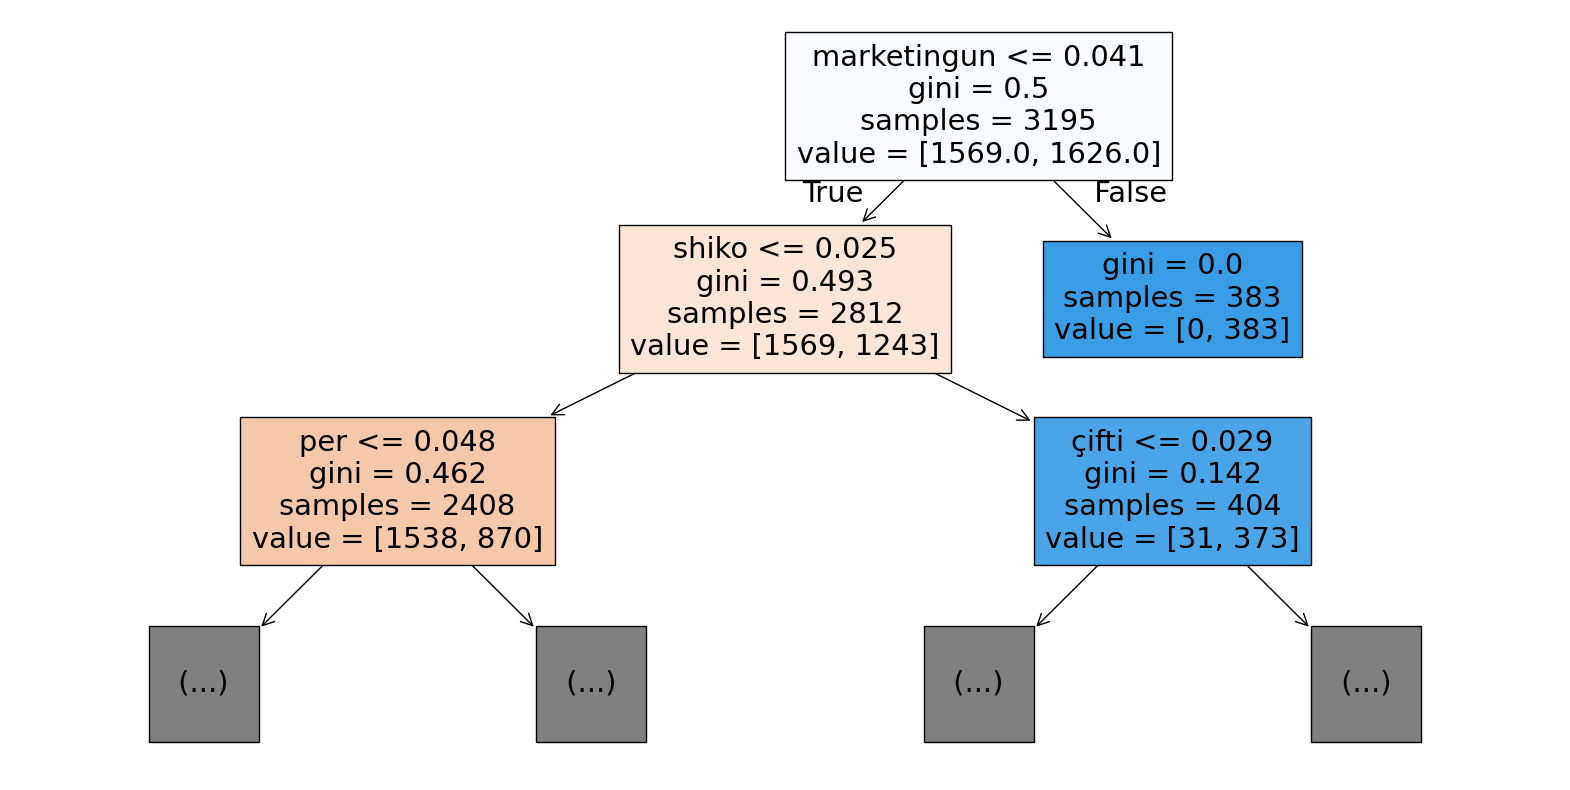

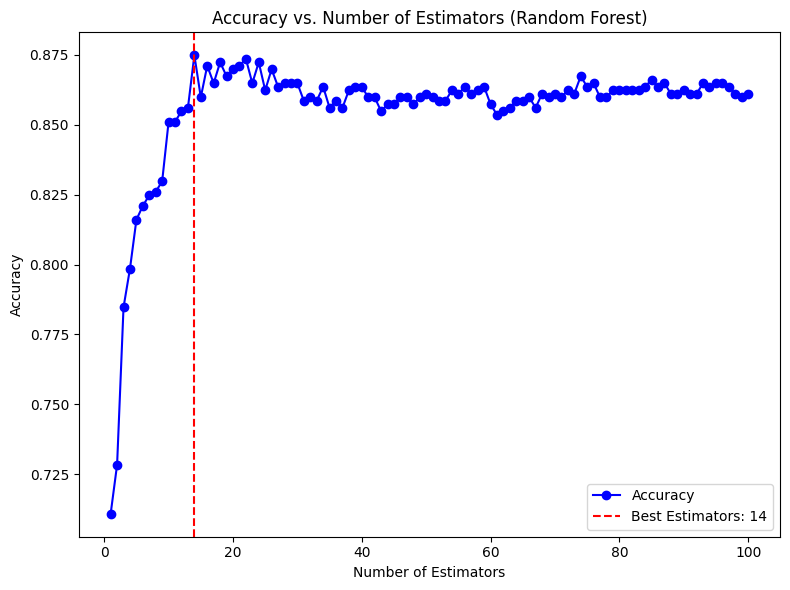

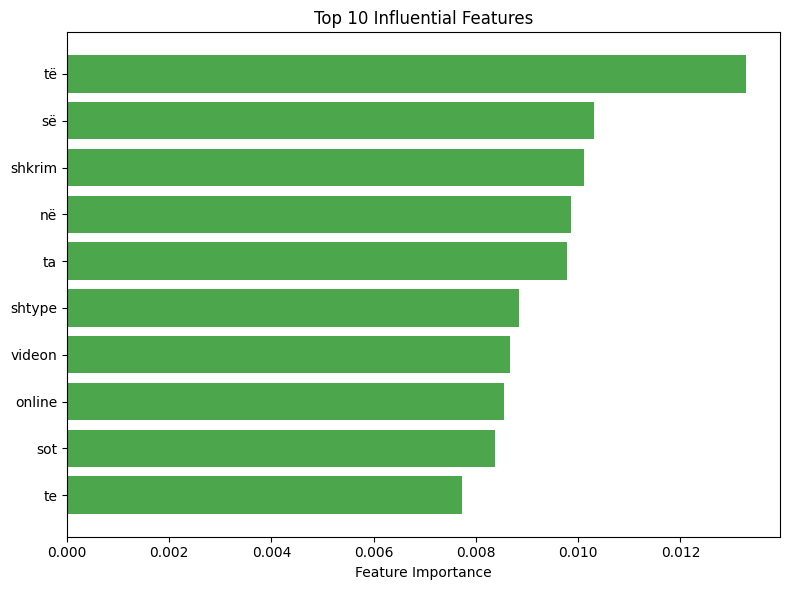


Best Number of Estimators: 14
Best Accuracy: 0.87
Logistic Regression Accuracy: 0.87
Hybrid Model Accuracy: 0.8485607008760951

Classification Report:
              precision    recall  f1-score   support

       False       0.79      0.98      0.87       429
        True       0.97      0.70      0.81       370

    accuracy                           0.85       799
   macro avg       0.88      0.84      0.84       799
weighted avg       0.87      0.85      0.84       799



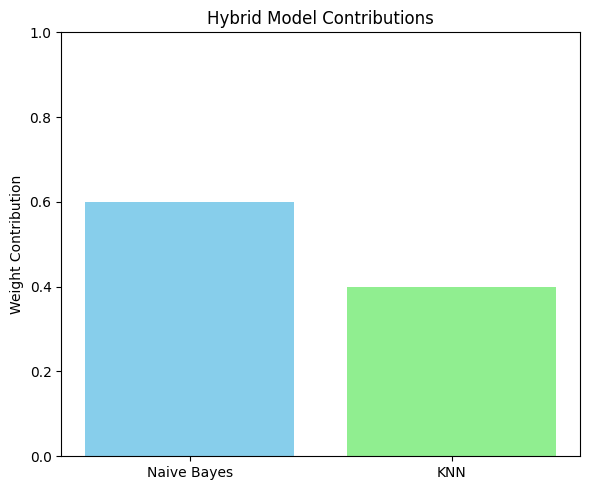

Hybrid NB + LR Accuracy: 0.8886107634543179

Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.90      0.90       429
        True       0.88      0.88      0.88       370

    accuracy                           0.89       799
   macro avg       0.89      0.89      0.89       799
weighted avg       0.89      0.89      0.89       799



In [61]:
accuracies['albanian']['naive_bayes'] = naive_bayes_classifier_count(albanian, 'content', 'fake_news')
accuracies['albanian']['knn'] = knn_classifier(albanian, 'content', 'fake_news')
accuracies['albanian']['svm'] = svm_classifier(albanian, 'content', 'fake_news')
accuracies['albanian']['decision_tree'] = decision_tree_classifier(albanian, 'content', 'fake_news')
accuracies['albanian']['random_forest'] = random_forest_classifier(albanian, 'content', 'fake_news')
accuracies['albanian']['logistic_regression'] = logistic_regression_classifier(albanian, 'content', 'fake_news')
accuracies['albanian']['knn/naive_bayes'] = hybrid_knn_naive_bayes(albanian, 'content', 'fake_news')
accuracies['albanian']['nb/lr'] = hybrid_nb_lr(albanian, 'content', 'fake_news')

KNN Accuracy: 0.60

Classification Report:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71      4015
           1       0.99      0.23      0.38      4359

    accuracy                           0.60      8374
   macro avg       0.77      0.62      0.54      8374
weighted avg       0.78      0.60      0.54      8374


Top 10 Influential Features:
Feature: the, Score: 0.1099
Feature: of, Score: 0.0532
Feature: al, Score: 0.0446
Feature: and, Score: 0.0444
Feature: in, Score: 0.0423
Feature: to, Score: 0.0373
Feature: is, Score: 0.0341
Feature: ahly, Score: 0.0299
Feature: for, Score: 0.0264
Feature: team, Score: 0.0253


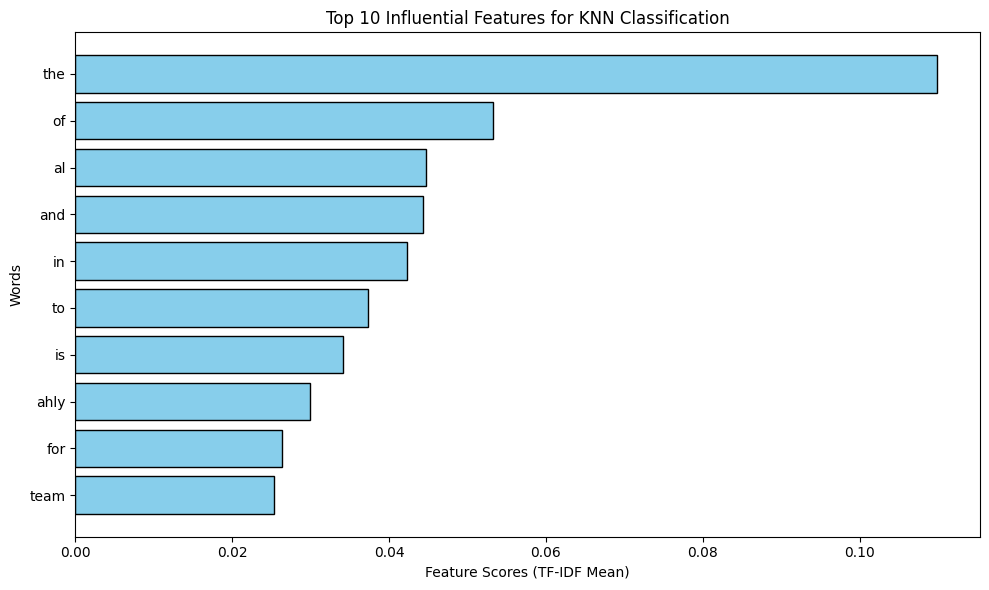

Logistic Regression Accuracy: 0.92
Hybrid Model Accuracy: 0.9401719608311441

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      4015
           1       0.97      0.91      0.94      4359

    accuracy                           0.94      8374
   macro avg       0.94      0.94      0.94      8374
weighted avg       0.94      0.94      0.94      8374



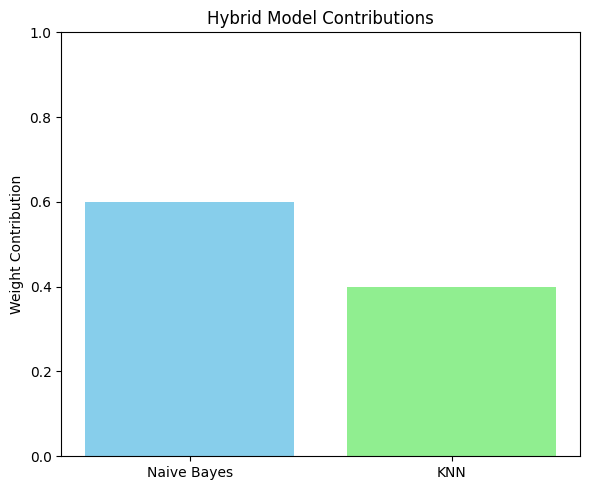

Hybrid NB + LR Accuracy: 0.9407690470503941

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      4015
           1       0.95      0.94      0.94      4359

    accuracy                           0.94      8374
   macro avg       0.94      0.94      0.94      8374
weighted avg       0.94      0.94      0.94      8374



In [62]:
accuracies['soccer']['naive_bayes'] = naive_bayes_classifier_count(soccer, 'tweet', 'real')
accuracies['soccer']['knn'] = knn_classifier(soccer, 'tweet', 'real')
#accuracies['soccer']['svm'] = svm_classifier(soccer, 'tweet', 'real')
#accuracies['soccer']['decision_tree'] = decision_tree_classifier(soccer, 'tweet', 'real')
#accuracies['soccer']['random_forest'] = random_forest_classifier(soccer, 'tweet', 'real')
accuracies['soccer']['logistic_regression'] = logistic_regression_classifier(soccer, 'tweet', 'real')
accuracies['soccer']['knn/naive_bayes'] = hybrid_knn_naive_bayes(soccer, 'tweet', 'real')
accuracies['soccer']['nb/lr'] = hybrid_nb_lr(soccer, 'tweet', 'real')

SVM Accuracy: 0.85

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        91
           1       0.93      0.78      0.85       109

    accuracy                           0.85       200
   macro avg       0.86      0.86      0.85       200
weighted avg       0.86      0.85      0.85       200



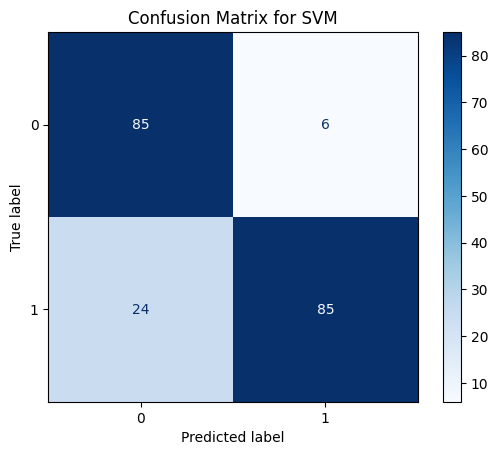


Best Max Depth: 24
Best Accuracy: 0.84

Top 10 Influential Features:


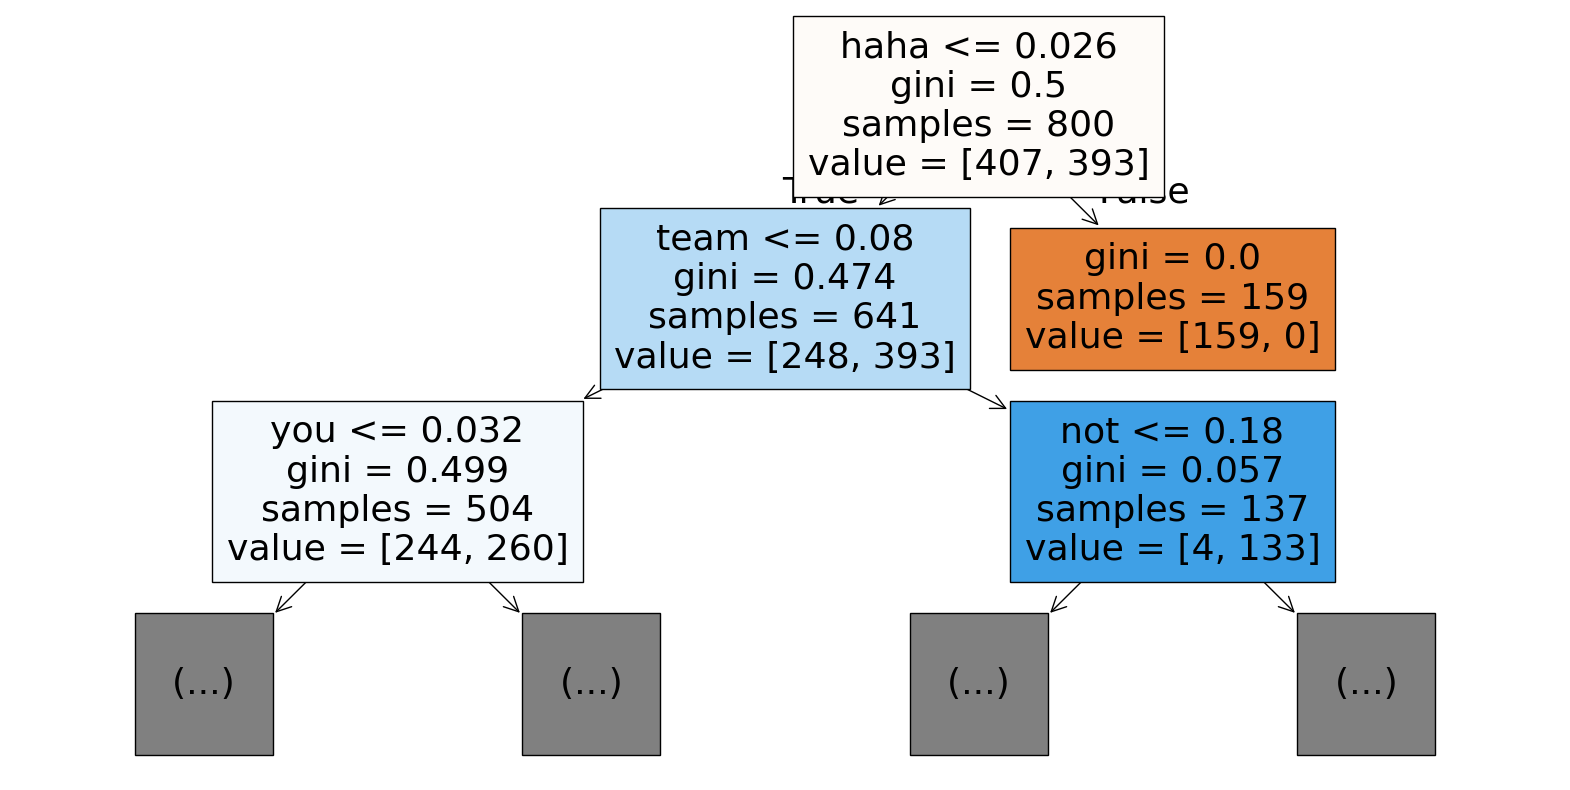

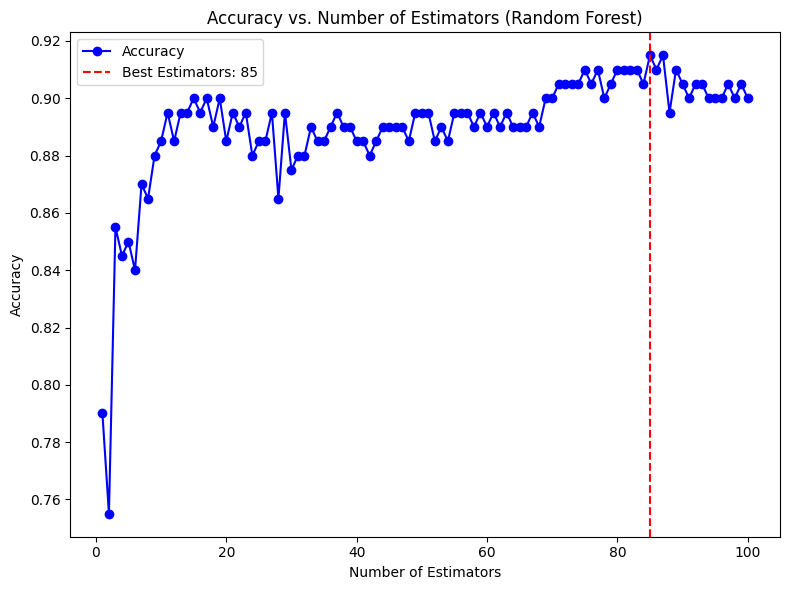

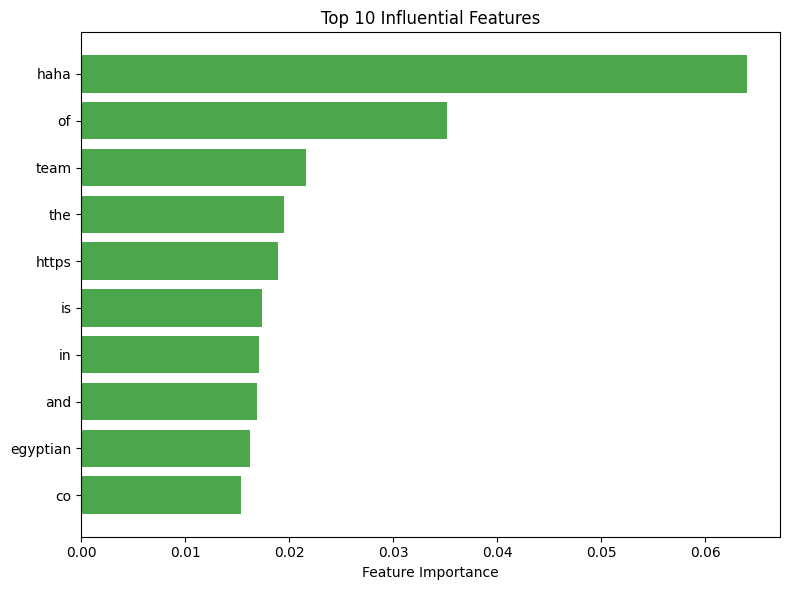


Best Number of Estimators: 85
Best Accuracy: 0.92


In [63]:
soccer_small = soccer.sample(1000)
accuracies['soccer']['svm'] = svm_classifier(soccer_small, 'tweet', 'real')
accuracies['soccer']['decision_tree'] = decision_tree_classifier(soccer_small, 'tweet', 'real')
accuracies['soccer']['random_forest'] = random_forest_classifier(soccer_small, 'tweet', 'real')

In [64]:
accuracies = pd.DataFrame(accuracies)
print(accuracies)

                                                              albanian  \
naive_bayes                                                       None   
knn                  (0.723404255319149, [(të, 0.13930901419137837)...   
svm                                                            0.68836   
decision_tree                            (0.851063829787234, 17, None)   
random_forest        (0.8748435544430538, 14, [(të, 0.0132837332880...   
logistic_regression                                           0.866083   
knn/naive_bayes                                               0.848561   
nb/lr                                                         0.888611   

                                                                soccer  \
naive_bayes                                                       None   
knn                  (0.60019106759016, [(the, 0.10985208082181994)...   
svm                                                               0.85   
decision_tree                        

In [65]:
print(albanian.shape)
print(soccer.shape)

(3994, 21)
(41868, 3)
